#### <ins>Imports/Installs</ins>



##### Installing required packages (if missing)

In [212]:
# !pip install pandas
# !pip install matplotlib
# !pip install scikit-learn
# !pip install xgboost

##### Import required libs

In [213]:
import pandas as pd

import matplotlib.pyplot as pyplot

from sklearn import metrics
from sklearn.metrics import accuracy_score

from xgboost import XGBClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

##### Importing Dataset.csv

In [214]:
data = pd.read_csv('../datasets/har/heart_attack_risk_dataset.csv')

##### Inspecting The Dataset

In [215]:
def printSummaryStatistics():   # Prints statistical for each column in the dataframe
    dataCols = data.columns.to_list()
    for col in dataCols:
        print(f"Column: {col} \n{data[col].describe()} \nData Type: {data[col].dtype}\n")

print(f'{data.head()}\n')       # Looking into basic structure
printSummaryStatistics()


   Age  Gender  Smoking  Alcohol_Consumption Physical_Activity_Level    BMI  \
0   69  Female        1                    0                Moderate  34.61   
1   32    Male        0                    0                Moderate  22.75   
2   89    Male        0                    1                Moderate  35.32   
3   78    Male        0                    1                Moderate  18.23   
4   38  Female        1                    0                Moderate  19.82   

   Diabetes  Hypertension  Cholesterol_Level  Resting_BP  Heart_Rate  \
0         1             0              152.1         171          85   
1         0             0              166.8         126         103   
2         0             0              272.3         123         127   
3         1             0              237.7         144         125   
4         0             0              207.7         123         107   

   Family_History Stress_Level Chest_Pain_Type        Thalassemia  \
0               0     M

#### <ins>Data Preprocessing and Training</ins>

##### Initializing Encoders

In [216]:
leGender = LabelEncoder()       # Female, Male
leHML = LabelEncoder()          # High, Moderate, Low
leChestPain = LabelEncoder()    # Non-anginal, Asymptomatic, Typical, Atypical
leThalassemia = LabelEncoder()  # Normal, Fixed Defect, Reversible Defect
leECG = LabelEncoder()          # Normal, ST-T abnormality, Left ventricular hypertrophy

##### Encoding Categorical Columns

In [217]:
data['Gender'] = leGender.fit_transform(data['Gender'])

data['Physical_Activity_Level'] = leHML.fit_transform(data['Physical_Activity_Level'])
data['Stress_Level'] = leHML.fit_transform(data['Stress_Level'])
data['Heart_Attack_Risk'] = leHML.fit_transform(data['Heart_Attack_Risk'])

data['Chest_Pain_Type'] = leChestPain.fit_transform(data['Chest_Pain_Type'])
data['Thalassemia'] = leThalassemia.fit_transform(data['Thalassemia'])
data['ECG_Results'] = leECG.fit_transform(data['ECG_Results'])

##### Forming Dataset into Training, Test, Eval, Features and Labels

In [218]:
x_data = data.iloc[:,:19]       # Features
y_data = data.iloc[:,19:]       # Labels

xtrain, xtest, ytrain, ytest = train_test_split(
    x_data, 
    y_data, 
    test_size=0.2,
    random_state=0
)

evaldata=[(xtrain,ytrain),(xtest,ytest)]          # Datensatz zur Evaluierung

##### Training and Improving<br>
Um eine gute Anzahl an Estimators zu bestimmen, wird zuerst ein Modell mithilfe von Early Stopping, sowie einer großen Menge an Estimatoren trainiert. Hiermit wird die beste Anzahl an Iterationen ermittelt und mit dieser Anzahl ein weiteres Modell trainiert.

In [219]:
donor = XGBClassifier(              # "Spendermodell"
    objective='multi:softmax',      # Multi-Klassifizierung
    num_class=3,
    learning_rate=0.1,
    n_estimators=10000,             # "Große Anzahl an Schaetzern, die nicht erreicht werden soll"
    early_stopping_rounds=50,       # Anzahl an Runden, bei denen sich das Modell nicht verbessern muss, bis abgebrochen wird
    # max_depth=3                   # Erstmal weglassen
)

donor.fit( # Donor model
    xtrain, 
    ytrain, 
    eval_set=evaldata, 
    verbose=False
)

bIter = donor.best_iteration        # Beste Anzahl an Estimatoren

model = XGBClassifier(
    objective='multi:softmax',  # Specify the multi-class classification task
    num_class=3,                # Number of classes (Low, Moderate, High)
    learning_rate=0.1,          # Learning rate for the model
    n_estimators=bIter,         # Number of boosting rounds (iterations)
    num_parallel_tree=1         # m2c workaround
    # max_depth=3,              # Maximum depth of the trees
)

model.fit( # Final model
    xtrain, 
    ytrain, 
    eval_set=evaldata, 
    verbose=False
)

print(model.classes_)

yhat = model.predict(xtest)

[0 1 2]


#### <ins>Func Definitions</ins>

##### Performance Metrics and Evaluation

In [ ]:
def printConfusionMatrix(): # Confusion Matrix
    metrics.ConfusionMatrixDisplay.from_estimator(model, xtest, ytest, cmap='Blues')
    pyplot.show()

def plotLossCurves():       # Loss Curves
    # save evaluation results
    results = model.evals_result()
    # plot curves
    lossValue = list(results['validation_1'])[0]
    pyplot.plot(results['validation_0'][lossValue], label='train')
    pyplot.plot(results['validation_1'][lossValue], label='train')
    # show the legend
    pyplot.xlabel('Iterations')
    pyplot.ylabel('Log Loss')
    pyplot.legend()
    # show the plot
    pyplot.show()

def printClassReport():     # Classification Report
    # Report
    print(metrics.classification_report(ytest, yhat, digits = 3))

def printMisc():            # Best Iter, Test Accuracy, Base Score, Probas,
    # Misc
    print(f'# Trees / Best Iteration: \t{bIter}')
    print(f'Test Accuracy: \t{accuracy_score(ytest, yhat)}')
    print(f'Base_Score{model.base_score}')
    print(f'\nPredict_Proba Return: \n{model.predict_proba(xtest)}')

##### Porting this Bitch

In [ ]:
def portToC(model):
    import m2cgen as m2c

    with open('../exported_models/currentExport.c','w') as f:
        code = m2c.export_to_c(model)
        f.write(code)
        

##### Generating Code for Lazy People

In [222]:
def genInfer(start=0, size=500, csv=True, float=True):
    start = start
    size = size
    length = 2
    
    # Declaring function
    print(f'void infer(int time, int csv) {{')

    # Printing Header
    print(f'\tif(csv==1){{')
    print(f'\t\tSerial.println("aScore0,aScore1");        // Printing header to name columns in csv')
    print(f'\t}} else {{')
    print(f'\t\tSerial.println("Start: {start} | End: {start+size}");    // Printing Range:')
    print(f'\t}}')

    print(f'\t// Declarations:')
    print(f'\tint length = {length};')
    if float == True:
        print(f'\tfloat result[length];')
    else:
        print(f'\tdouble result[length];')

    print(f'\t// Model Inference')
    for x in range(start,(start+size)):  
        if float == True:
            print(f'\tfloat x_{x}[] = {{' , end="")    
        else:
            print(f'\tdouble x_{x}[] = {{' , end="")
        features = xtest.values[x]
        for i in range(len(features)):
            if i < (len(features)-1):
                print(features[i], end=", ")
            else:
                print(features[i], end="};\n")
        print(f'\tint y_{x} = {yhat[x]};')
        print(f'\tscore(x_{x}, result);')
        if csv == True:
            print(f'\tprintScoreCSV(result, length, y_{x});')
        else:
            print(f'\tprintScoreCompare(result, length, y_{x});')
        
        print(f'\tdelay(time);\n')
    print(f'}}')

##### <ins>Generating Inference Data</ins>

In [ ]:
def generateProbDF(localCapture=model,features_test=xtest):
    xtestlist = localCapture.predict_proba(features_test).tolist()
    list1 = []
    list2 = []

    for x in xtestlist:
        list1.append(round(x[0],4))
        list2.append(round(x[1],4))

    probDF = pd.DataFrame({
        'Label': localCapture.predict(features_test),
        'Prob0': list1,
        'Prob1': list2
    })
    return(probDF)

def exportProbDF(probDF = generateProbDF()):
    probDF.to_csv('../datasets/har/baseCapture.csv')

def importInoCapture():
    serial = pd.read_csv('../datasets/har/inoCapture.csv')
    serial = serial.truncate(after=(len(serial)-2)) # get rid of ##### REPEATING... #####
    return(serial)

def generateComparison(probDF=generateProbDF(),inoCapture=importInoCapture()):
    probDF = probDF.truncate(after=(len(inoCapture)-1))
    probDF = probDF.join(inoCapture)
    probDF.to_csv('../datasets/har/compareCaptures.csv')

#### <ins>Main</ins>

##### Evaluation Metrics

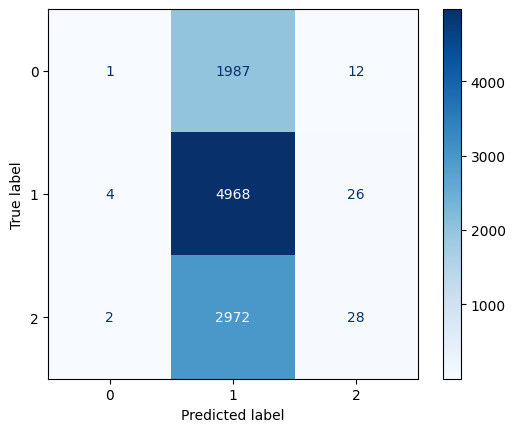

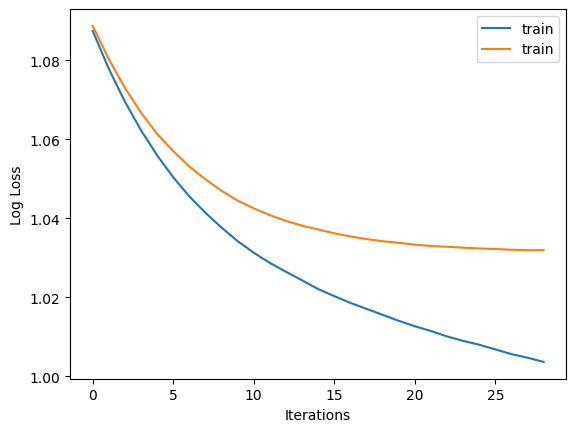

              precision    recall  f1-score   support

           0      0.143     0.001     0.001      2000
           1      0.500     0.994     0.666      4998
           2      0.424     0.009     0.018      3002

    accuracy                          0.500     10000
   macro avg      0.356     0.335     0.228     10000
weighted avg      0.406     0.500     0.338     10000

# Trees: 	29
Test Accuracy: 	0.4997
Base_ScoreNone
Best Iteration: 29

Predict_Proba Return: 
[[0.21152776 0.47773477 0.31073752]
 [0.1864701  0.5065712  0.3069587 ]
 [0.20570506 0.48622683 0.30806807]
 ...
 [0.20900981 0.47849387 0.3124963 ]
 [0.234804   0.4724323  0.29276368]
 [0.22678567 0.4838346  0.28937972]]


In [224]:
printConfusionMatrix()
plotLossCurves()
printClassReport()
printMisc()

##### Code Generation

In [228]:
genInfer(start=0, size=500, csv=True, float=False)

void infer(int time, int csv) {
	if(csv==1){
		Serial.println("aScore0,aScore1");        // Printing header to name columns in csv
	} else {
		Serial.println("Start: 0 | End: 500");    // Printing Range:
	}
	// Declarations:
	int length = 2;
	double result[length];
	// Model Inference
	double x_0[] = {73.0, 0.0, 1.0, 1.0, 0.0, 35.67, 0.0, 0.0, 241.3, 144.0, 127.0, 0.0, 2.0, 1.0, 2.0, 0.0, 1.0, 1.0, 175.0};
	int y_0 = 1;
	score(x_0, result);
	printScoreCSV(result, length, y_0);
	delay(time);

	double x_1[] = {82.0, 0.0, 0.0, 1.0, 1.0, 24.59, 1.0, 0.0, 174.4, 131.0, 73.0, 1.0, 2.0, 2.0, 0.0, 0.0, 2.0, 0.0, 160.0};
	int y_1 = 1;
	score(x_1, result);
	printScoreCSV(result, length, y_1);
	delay(time);

	double x_2[] = {72.0, 0.0, 0.0, 1.0, 2.0, 27.4, 0.0, 0.0, 151.8, 147.0, 100.0, 1.0, 2.0, 2.0, 2.0, 0.0, 2.0, 0.0, 197.0};
	int y_2 = 1;
	score(x_2, result);
	printScoreCSV(result, length, y_2);
	delay(time);

	double x_3[] = {82.0, 0.0, 0.0, 0.0, 1.0, 28.67, 0.0, 0.0, 174.2, 156.0, 95.0, 1.0

##### Generate C-Port

In [ ]:
portToC(model)

##### Generate Inference Data and Comparison

In [227]:
# generateProbDF()      # params: localCapture (model to capture data from), features_test
# exportProbDF()        # params: probDF (probDF export)
# importInoCapture()    
# generateComparison()  # params: probDF, inoCapture